<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/6_IWAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **1. Preparing data**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # 이진화
])

In [ ]:
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# **2. Modeling**

## **2-1. VAE**

In [ ]:
class VAE(nn.Module):
    def __init__(self, architecture, latent_dim=50):
        super(VAE, self).__init__()

        self.architecture = architecture
        self.latent_dim = latent_dim

        if architecture == 1:
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(28*28, 200),
                nn.Tanh(),
                nn.Linear(200, 200),
                nn.Tanh()
            )
            self.fc_mean = nn.Linear(200, self.latent_dim)
            self.fc_logvar = nn.Linear(200, self.latent_dim)

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(self.latent_dim, 200),
                nn.Tanh(),
                nn.Linear(200, 200),
                nn.Tanh(),
                nn.Linear(200, 28*28),
                nn.Sigmoid()
            )

        elif architecture == 2:
            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(28*28, 200),
                nn.Tanh(),
                nn.Linear(200, 100),
                nn.Tanh()
            )
            self.fc_mean1 = nn.Linear(100, 100)
            self.fc_logvar1 = nn.Linear(100, 100)
            self.fc_mean2 = nn.Linear(100, self.latent_dim)
            self.fc_logvar2 = nn.Linear(100, self.latent_dim)

            self.middle = nn.Sequential(
                nn.Linear(self.latent_dim, 100),
                nn.Tanh(),
                nn.Linear(100, 100),
                nn.Tanh()
            )

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(100, 200),
                nn.Tanh(),
                nn.Linear(200, 200),
                nn.Tanh(),
                nn.Linear(200, 28*28),
                nn.Sigmoid()
            )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mean + std * epsilon

    def forward(self, x, k=1):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # (batch_size, 28*28)

        if self.architecture == 1:
            # Encoding
            h = self.encoder(x)  # (batch_size, 200)
            mu_z = self.fc_mean(h)  # (batch_size, latent_dim)
            log_var_z = self.fc_logvar(h)  # (batch_size, latent_dim)

            # Reparameterizing
            z = self.reparameterize(mu_z, log_var_z)  # (batch_size, latent_dim)
            z = z.unsqueeze(1).repeat(1, k, 1)  # (batch_size, k, latent_dim)

            # Decoding
            x_hat = self.decoder(z)  # (batch_size, k, 28*28)
            return x_hat, mu_z, log_var_z

        elif self.architecture == 2:
            h = self.encoder(x)  # (batch_size, 100)
            mu_z1 = self.fc_mean1(h)  # (batch_size, 100)
            log_var_z1 = self.fc_logvar1(h)  # (batch_size, 100)

            z1 = self.reparameterize(mu_z1, log_var_z1)  # (batch_size, 100)

            h = self.middle(z1)  # (batch_size, 100)
            mu_z2 = self.fc_mean2(h)  # (batch_size, latent_dim)
            log_var_z2 = self.fc_logvar2(h)  # (batch_size, latent_dim)

            z2 = self.reparameterize(mu_z2, log_var_z2)  # (batch_size, latent_dim)
            z2 = z2.unsqueeze(1).repeat(1, k, 1)  # (batch_size, k, latent_dim)

            x_hat = self.decoder(z2)  # (batch_size, k, 28*28)
            return x_hat, mu_z2, log_var_z2

In [ ]:
class IWAE(VAE):
    pass  # IWAE는 VAE를 상속받아 별도 정의 없이 사용 가능

# **3. Loss 정의**

## **3-1. Training**
- VAE와 IWAE의 lower bound를 정의하고, 이들을 최적화하는 방향으로 학습

### **VAE**
- VAE는 **Evidence Lower Bound (ELBO)**를 최대화하는 방식으로 학습됨
- ELBO는 아래와 같은 형태임:
$$\text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log p(x|h)\right] - \text{KL}(q(h|x) \| p(h))$$
---
${L}^{\text{VAE}}{(x)}   =   \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log \frac{p_(x, z_k)}{q_(z_i | x)} \right] =  \frac{1}{k} \left[ \sum_{i=1}^{k}\frac{p_(x, z_k)}{q_(z_i | x)}  \right] \\ = -D_{KL}(q_(z_| x)||p(z)) + \frac{1}{k} \sum_{i=1}^{k} (\log p(x|z_i)) $

In [ ]:
def vae_loss(x, x_hat, mu_z, log_var_z):
    k = x_hat.shape[1]
    x = x.view(-1, 1, 28*28).expand(-1, k, 28*28)  # (batch_size, k, 28*28)

    # Reconstruction loss (negative log-likelihood)
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())

    # ELBO
    elbo_vae = recon_loss + kl_divergence

    return elbo_vae

### **IWAE**
- IWAE는 **Importance Weighted Autoencoder**로, VAE와 유사한 구조를 가지지만, 더 높은 표현 능력을 갖도록 샘플링된 \( k \)개의 샘플에 가중치를 부여함
- ${L}^{\text{IWAE}}_{\text{k}}{(x)}   \\ =   \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log (\frac{1}{k} \sum_{i=1}^{k} \frac{p_(x, z_k)}{q_(z_i | x)}) \right]   \\ =   \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log (\frac{1}{k} \sum_{i=1}^{k} w_i) \right] \\ = \mathbb{E}_{z_1, \dots, z_k \sim q_(z|x)} \left[ \log \frac{1}{k} + \log \sum_{i=1}^{k} w_i \right]$


In [ ]:
def iwae_loss(x, x_hat, mu_z, log_var_z):
    k = x_hat.shape[1]
    batch_size = x.size(0)

    # Reshape x for broadcasting
    x = x.view(batch_size, 1, 28*28).expand(-1, k, 28*28)  # (batch_size, k, 28*28)

    # Reshape mu_z and log_var_z for broadcasting
    mu_z = mu_z.unsqueeze(1)            # (batch_size, 1, latent_dim)
    log_var_z = log_var_z.unsqueeze(1)  # (batch_size, 1, latent_dim)

    # Log likelihood log p(x|z)
    log_p_x_given_z = -F.binary_cross_entropy(x_hat, x, reduction='none').sum(dim=-1)  # (batch_size, k)

    # KL divergence components
    kl_divergence = -0.5 * (1 + log_var_z - mu_z.pow(2) - log_var_z.exp()).sum(dim=-1)  # (batch_size, k)

    # Log weights: log w_i = log p(x|z) - KL(q(z|x) || p(z))
    log_w = log_p_x_given_z - kl_divergence  # (batch_size, k)

    # Numerical stability with Log-sum-exp trick
    log_sum_w = torch.logsumexp(log_w, dim=1)  # (batch_size,)

    # IWAE loss
    elbo_iwae = -(log_sum_w - torch.log(torch.tensor(k, dtype=torch.float32)))  # (batch_size,)

    return elbo_iwae.sum()  # Sum across the batch

## **3-2. Testing**
- Negative Log Likelihood 활용
- 이때, true likelihood를 계산할 수는 없음
  - 근사치 활용
  - IWAE의 $L_{5000}$ 활용


In [ ]:
def calculate_nll(model, test_loader, k=5000):
    model.eval()
    nll = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_hat, mu_z, log_var_z = model(x, k=k)
            loss = iwae_loss(x, x_hat, mu_z, log_var_z)
            nll += loss.item()
    nll /= len(test_loader.dataset)  # testing 시의 average loss
    return nll

# **4. Training & Testing**

## **4-1. Training**

In [ ]:
def train(model, optimizer, data_loader, num_epochs=10, k=1):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, _ in data_loader:
            x = x.to(device)
            optimizer.zero_grad()

            x_hat, mu_z, log_var_z = model(x, k=k)
            if isinstance(model, IWAE):
                loss = iwae_loss(x, x_hat, mu_z, log_var_z)
            else:
                loss = vae_loss(x, x_hat, mu_z, log_var_z)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return losses

## **4-2. Testing**

**활성 unit 개수 측정**

In [ ]:
def compute_active_units(model, data_loader, threshold=1e-2):
    model.eval()
    active_units = torch.zeros(model.latent_dim).to(device)
    with torch.no_grad():
        # 저장된 잠재 벡터들을 추적
        mu_zs = []

        for x, _ in data_loader:
            x = x.to(device)
            _, mu_z, _ = model(x)
            mu_zs.append(mu_z.cpu().numpy())

        mu_zs = np.concatenate(mu_zs, axis=0)  # (전체 데이터 샘플 수, latent_dim)

        # 각 차원에 대한 공분산 계산
        for i in range(model.latent_dim):
            var = np.var(mu_zs[:, i])  # 각 차원 i에 대한 분산
            if var > threshold:
                active_units[i] = 1

    return active_units.sum().item()

In [ ]:
def evaluate(model, data_loader):
    nll = calculate_nll(model, data_loader, k=5000)
    active_units = compute_active_units(model, data_loader)
    return nll, active_units

# **5. RUN!!**

**시각화**

In [ ]:
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        x_hat, _, _ = model(x)

        x = x.cpu().numpy()
        x_hat = x_hat.squeeze().cpu().numpy()

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
            axes[0, i].imshow(x[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Reshape x_hat[i] if necessary based on its actual shape
            axes[1, i].imshow(x_hat[i].reshape(28, 28), cmap='gray')
            axes[1, i].set_title('Reconstruction')
            axes[1, i].axis('off')

        plt.show()

In [ ]:
def run(architecture=1, k=5):
    vae = VAE(architecture=architecture, latent_dim=50).to(device)
    iwae = IWAE(architecture=architecture, latent_dim=50).to(device)

    vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)
    iwae_optimizer = optim.Adam(iwae.parameters(), lr=0.001)

    print(f"Training VAE with architecture {architecture}...")
    elbo_values_vae = train(vae, vae_optimizer, train_loader, num_epochs=27, k=k)
    print(f"Evaluating VAE with architecture {architecture}...")
    nll_vae, active_units_vae = evaluate(vae, test_loader)
    print(f"VAE NLL with architecture {architecture} and k={k}: ", nll_vae)
    print(f"VAE Active Units with architecture {architecture} and k={k}: ", active_units_vae)

    print()

    print(f"Training IWAE with architecture {architecture} and k={k}...")
    elbo_values_iwae = train(iwae, iwae_optimizer, train_loader, num_epochs=27, k=k)
    print(f"Evaluating IWAE with architecture {architecture} and k={k}...")
    nll_iwae, active_units_iwae = evaluate(iwae, test_loader)
    print(f"IWAE NLL with architecture {architecture} and k={k}: ", nll_iwae)
    print(f"IWAE Active Units with architecture {architecture} and k={k}: ", active_units_iwae)

    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(elbo_values_vae, label=f'VAE Architecture {architecture} (k={k})', color='blue')
    plt.plot(elbo_values_iwae, label=f'IWAE Architecture {architecture} (k={k})', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves for Architecture {architecture} (k={k})')
    plt.legend()
    plt.show()

    visualize_reconstruction(vae, test_loader)
    visualize_reconstruction(iwae, test_loader)

## **5-1. Case 1**
- model = 1
- k = 5

Training VAE with architecture 1...
Epoch [1/27], Loss: 734.4772
Epoch [2/27], Loss: 471.0609
Epoch [3/27], Loss: 399.4484
Epoch [4/27], Loss: 365.5226
Epoch [5/27], Loss: 343.4681
Epoch [6/27], Loss: 329.1356
Epoch [7/27], Loss: 319.0737
Epoch [8/27], Loss: 310.3031
Epoch [9/27], Loss: 303.9379
Epoch [10/27], Loss: 299.0389
Epoch [11/27], Loss: 294.9980
Epoch [12/27], Loss: 291.9109
Epoch [13/27], Loss: 288.6496
Epoch [14/27], Loss: 285.8716
Epoch [15/27], Loss: 282.7459
Epoch [16/27], Loss: 280.5626
Epoch [17/27], Loss: 278.0984
Epoch [18/27], Loss: 276.1286
Epoch [19/27], Loss: 274.4634
Epoch [20/27], Loss: 273.0263
Epoch [21/27], Loss: 271.2805
Epoch [22/27], Loss: 270.1865
Epoch [23/27], Loss: 269.1285
Epoch [24/27], Loss: 267.8783
Epoch [25/27], Loss: 266.9055
Epoch [26/27], Loss: 265.9994
Epoch [27/27], Loss: 265.2177
Evaluating VAE with architecture 1...
VAE NLL with architecture 1 and k=5:  98.88918364257813
VAE Active Units with architecture 1 and k=5:  29.0

Training IWAE wi

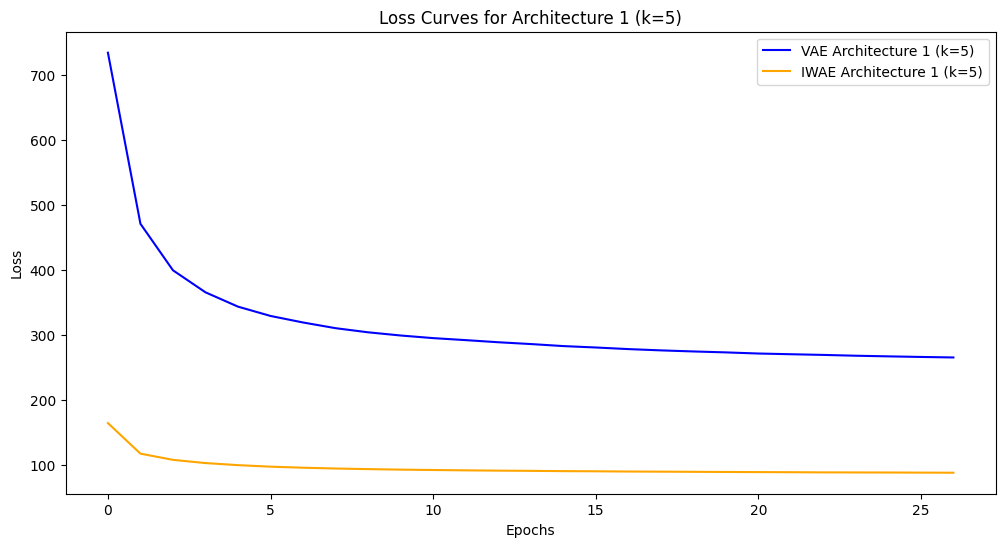

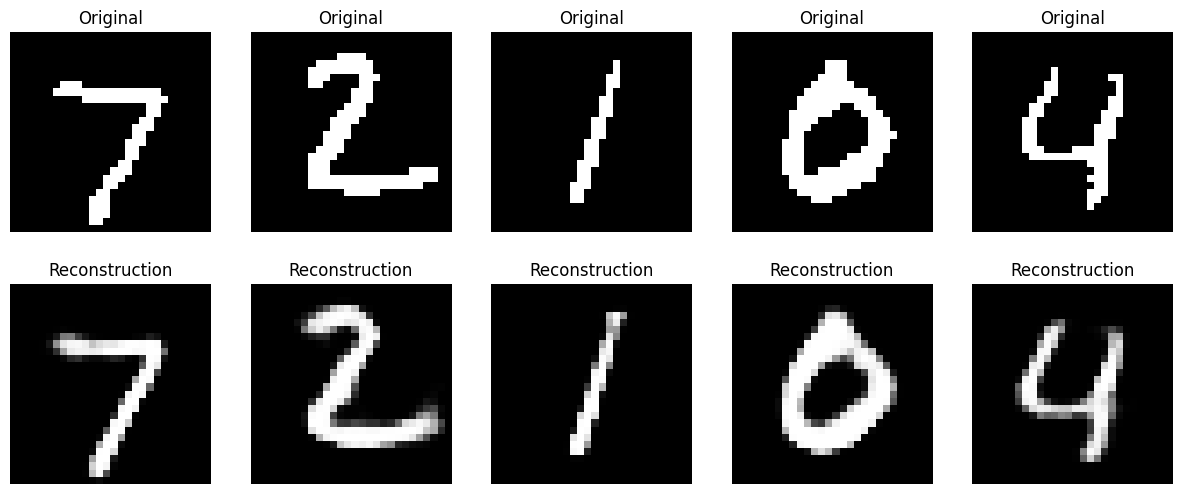

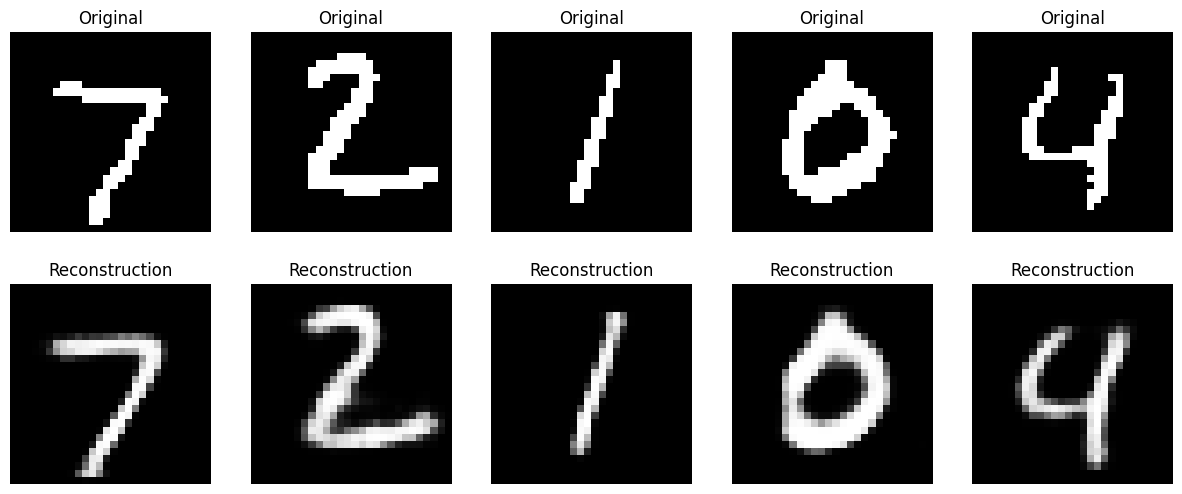

In [ ]:
run(architecture=1, k=5)